# Chata

WARNING: maskrcnn_benchmark.config load global variables - in case of RuntimeError: Error(s) in loading state_dict for GeneralizedRCNN: size mismatch (...) try restart kernel

In [1]:
model_index = "2018_05_15_tables"
model_type = "tables"
#model_output_dir = "./output/chata/2019_05_08" # directory with model checkpoints
model_output_dir = "./"

if model_type=="charts":
    congig_file_type = "chata"
else:
    config_file_type = "tables"

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import importlib
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from demo.predictor_chata import ChataDemo
from demo.predictor import COCODemo

import maskrcnn_benchmark.config as config
import cv2 as cv

In [3]:
# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

In [4]:
def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

In [5]:
def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

In [6]:
# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

# Chata

In [7]:
from maskrcnn_benchmark.data.datasets.chata import ChataDataset, TablesDataset
import imageio as imio
import os

In [8]:
# "train", "test", "val"
if model_type=="charts":
    dataset = ChataDataset("./datasets/chata/chata", "val")
elif model_type=="tables":
    dataset = TablesDataset("./datasets/chata/tables", "val")

In [9]:
def apply_filter(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        
    threshold, img = cv.threshold(img, 0, 255, cv.THRESH_OTSU)
    #plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        
    img = cv.distanceTransform(img, cv.DIST_L1, 0)
    #plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        
    img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    img = img.astype(np.uint8)
    return img

In [10]:
def save_sample_results(model_index, chata_demo, dataset, dataset_type="val", img_range=(0,20)):
    
    os.makedirs(f"chata_results/{model_index}_samples", exist_ok=True)

    for i in range(*img_range):
        test_img = np.array(dataset.__getitem__(i)[0])
        prediction = chata_demo.run_on_opencv_image(test_img)
        imio.imwrite(f'chata_results/{model_index}_samples/{dataset_type}_{i:2d}.jpg', prediction)

In [11]:
config_file = f"./configs/chata/e2e_faster_rcnn_R_50_C4_1x_1_gpu_voc_{config_file_type}.yaml"
config.cfg.merge_from_file(config_file)
config.cfg.merge_from_list(["MODEL.DEVICE", "cpu"])
config.cfg.merge_from_list(["OUTPUT_DIR", model_output_dir])

chata_demo = ChataDemo(
    config.cfg,
    model_type,
    min_image_size=800,
    confidence_threshold=0.5,
)

Loading checkpoint from ./model_0067500.pth
[Checkpointer._load_file] Model loading: ./model_0067500.pth


In [12]:
save_sample_results(model_index, chata_demo, dataset)

Labels: {'table': 0.6181277632713318}
Labels: {'table': 0.9108605980873108}
Labels: {'table': 0.7344174981117249}
Labels: {}
Labels: {}
Labels: {'table': 0.9365571141242981}
Labels: {'table': 0.9930777549743652}
Labels: {'table': 0.866852343082428}
Labels: {'table': 0.8895986080169678}
Labels: {}
Labels: {'table': 0.9981179237365723}
Labels: {'table': 0.6345638632774353}
Labels: {'table': 0.7879785299301147}
Labels: {}
Labels: {}
Labels: {'table': 0.9564141631126404}
Labels: {'table': 0.9995827078819275}
Labels: {'table': 0.9972847700119019}
Labels: {'table': 0.979953408241272}
Labels: {'table': 0.8210864067077637}


### Filter example

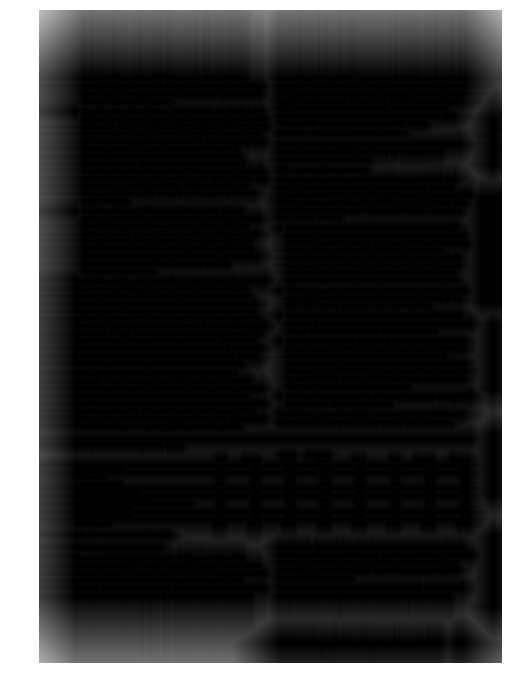

In [16]:
# Example
img = cv.imread('cTDaR_t10260.png')
img = apply_filter(img)
imshow(img)

Labels: {'table': 0.999991774559021}


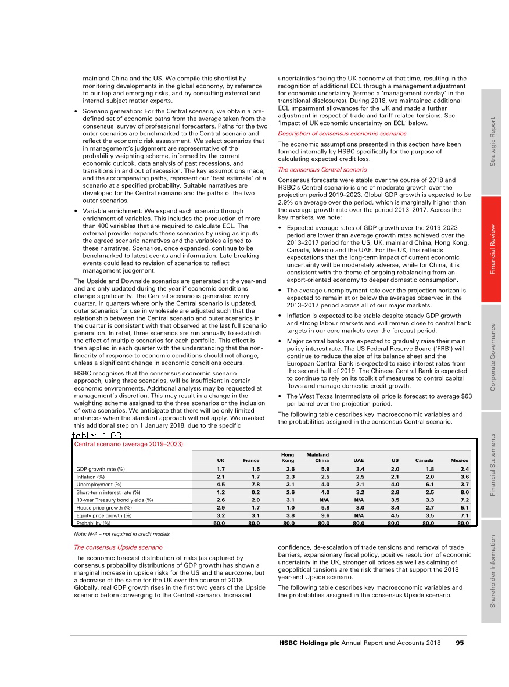

In [18]:
img = cv.imread('cTDaR_t10260.png')
prediction = chata_demo.run_on_opencv_image(img)
imshow(prediction)

# Training loss

In [14]:
import re

In [26]:
def print_loss(date, dataset_type="val", log_path=None):
    os.makedirs(f"./output/chata/{model_index}", exist_ok=True)
    os.makedirs(f"./chata_results/{model_index}", exist_ok=True)
    if log_path is None:
        log_path = f"./output/chata/{model_index}/log.txt"
    with open(log_path) as file:
        logs = file.read()

        for loss_type in ["loss", "loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"]:
            loss = re.findall(f"{loss_type}: [0-9]*.[0-9]* \([0-9]*.[0-9]*", logs)
            loss = [x[len(loss_type)+2:] for x in loss]
            
            iterations = re.findall(f"iter: [0-9]*", logs)
            iterations = [int(x[6:]) for x in iterations]
            
            plt.plot(iterations, [float(x.split("(")[0]) for x in loss])
            plt.plot(iterations, [float(x.split("(")[1]) for x in loss])
            plt.title(loss_type.upper())
            plt.xlabel('Iteration', fontsize=14)
            plt.ylabel('Loss value', fontsize=14)
            plt.savefig(f"./chata_results/{date}/{dataset_type}_{loss_type}.png")
            plt.clf()

In [36]:
print_loss(model_index, "val", "./log.txt")

<Figure size 1440x864 with 0 Axes>

# Test on real dataset

In [13]:
import cv2

In [14]:
catalog_names = os.listdir("chata_results/images")
catalogs = [f"chata_results/images/{name}" for name in catalog_names]

In [15]:
for catalog in catalogs:
    os.makedirs(f'{catalog}/{model_index}', exist_ok=True)
    for img_name in os.listdir(catalog):
        if "png" in img_name:
            test_img = cv2.imread(f"{catalog}/{img_name}")
            test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
            #imshow(test_img)
            prediction = chata_demo.run_on_opencv_image(test_img)
            imio.imwrite(f'{catalog}/{model_index}/{img_name}', prediction)

Labels: {}
Labels: {'table': 0.5912390351295471}
Labels: {}
Labels: {'table': 0.7189908027648926}
Labels: {}
Labels: {'table': 0.9999996423721313}
Labels: {'table': 0.99920254945755}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {'table': 0.68449467420578}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {'table': 0.9499477744102478}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {'table': 0.9999972581863403}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {'table': 0.9999815225601196}
Labels: {}
Labels: {'table': 0.7795243859291077}
Labels: {}
Labels: {}
Labels: {}
Labels: {}
Labels: {'table': 0.9999988079071045}
Labels: {}
Labels: {'table': 0.5679640173912048}
Lab